### Import necessary packages

In [ ]:
from dotenv import load_dotenv

from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

load_dotenv()

### Load LLM, Vector Store, and Embedding model

In [20]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [21]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

c:\Users\sjasm\Documents\gen-ai-exchange\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [ ]:
vector_store = Chroma(
    collection_name="FDA_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  
)

### Load Docs and perform Chunking

In [12]:
loader = PyPDFDirectoryLoader(
    path = "FDA_guidlineDocs",
    silent_errors = False,
    load_hidden = False,
    recursive = False,
    extraction_mode = "plain",
)

In [ ]:
docs = loader.load()

In [16]:
print(docs[0].page_content[:300])
print(docs[0].metadata)

48697696dft 
Regulatory Considerations 
for Prescription Drug Use-
Related Software  
 
Guidance for Industry 
 
 
 
 DRAFT GUIDANCE  
 
 This guidance document is being distributed for comment purposes only. 
 
Comments and suggestions regarding this draft document should be submitted within 90 day
{'producer': 'Adobe PDF Library 23.3.20', 'creator': 'Acrobat PDFMaker 23 for Word', 'creationdate': '2023-09-14T14:26:43-04:00', 'author': 'Wearne, Evan', 'company': 'FDA.CDER', 'contenttypeid': '0x010100711A2959D0A82541B5AA124D14A3ABE8', 'keywords': '', 'mediaserviceimagetags': '', 'moddate': '2023-09-14T14:26:47-04:00', 'order': '97000.000000', 'sourcemodified': '', 'subject': '', 'title': 'Guidance for Industry', '_dlc_dociditemguid': '1c74c394-c0d7-4dc7-8542-4421fee3da99', 'source': 'FDA_guidlineDocs\\48697696dft (1).pdf', 'total_pages': 19, 'page': 0, 'page_label': '1'}


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
print(len(all_splits)) ## text split into 1418 chunks

1418


### Index chunks

In [23]:
_ = vector_store.add_documents(documents=all_splits)

In [32]:
def retrieve_top_k_chucks(query: str, k: int) -> list:

    """Return top 'k' chunks with similarity score from vector_store"""

    results = []
    
    docs =  vector_store.similarity_search_with_score(query, k=k)

    for doc, score in docs:
        results.append({
                    "title": doc.metadata.get("title", "Untitled"),
                    "source": doc.metadata.get("source", "Unknown"),
                    "content": doc.page_content
        })
    
    return results


In [33]:
query = "I am working on medical devices OTS software"

results = retrieve_top_k_chucks(query = query, k = 3)

In [36]:
print(results[0])

{'title': 'Off-the-Shelf Software Use in Medical Devices', 'source': 'FDA_guidlineDocs\\Off-The-Shelf-Guidance_0.pdf', 'content': 'Contains Nonbinding Recommendations\n9\nassociated with the OTS Software. \n· Provide the results of the testing. \n· Is there a current list of OTS Software problems (bugs) and access to updates?\nFor more information on software testing, verification, and validation, please see section \nIII.C. \n6. How will you keep track of (control14) the OTS Software?\nAn appropriate plan should answer the following questions:\n· What measures have been designed into the medical device to prevent the introduction of \nincorrect versions? On startup, ideally, the medical device should check to verify that all \nsoftware is the correct title, version level, and configuration. If the correct software is not \nloaded, the medical device should warn the operator and shut down to a safe state.\n· How will you maintain the OTS software configuration?\n· Where and how will yo

### Integrating LLM with the retriever: using langgraph

In [44]:
from typing import TypedDict
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph

In [ ]:
## custom prompt with chat prompt template

custom_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Use the provided context to answer the question."),
    ("human", "Question: {question}\n\nContext:\n{context}\n\nAnswer:")
])

In [53]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


In [47]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [48]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_prompt.invoke({
        "question": state["question"],
        "context": docs_content
    })
    response = llm.invoke(messages)
    return {"answer": response.content}

In [49]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

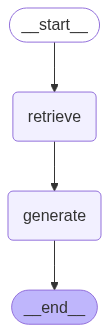

In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
result = graph.invoke({"question": "I am working on medical devices OTS software, what guidelines should i follow?"})

In [55]:
print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='17f7b3ac-5f72-4452-9a2f-dfb5c40c8415', metadata={'subject': '', 'producer': 'iTextSharp 4.0.3 (based on iText 2.0.2)', 'creator': 'CommonLook Office-2.1.5.37', 'creationdate': '2023-08-10T11:22:57-04:00', 'page_label': '10', 'page': 9, 'title': 'Off-the-Shelf Software Use in Medical Devices', 'source': 'FDA_guidlineDocs\\Off-The-Shelf-Guidance_0.pdf', 'nccl_standard': 'Section 508; WCAG 2.0 AA; PDF/UA', 'nccl_status': 'Passed', 'nccl_app': 'Office', 'keywords': '', 'moddate': '2024-02-07T10:04:10-05:00', 'part': '1', 'total_pages': 20, 'author': 'FDA CDRH'}, page_content='o Note: If the sponsor allows the use of the medical device with different versions of \nOTS software, then the sponsor should validate the medical device for each OTS \nsoftware version.\n· Provide a current list of OTS software defects.16\nD. Assurance of Development Methodologies and \nContinued Maintenance of OTS Software  \nGenerally, the following recommendations for premarket documentatio

In [ ]:
class ComplianceCheckerTool(BaseTool):
    name: str = "compliance_checker"
    description: str = "Validates test cases against regulatory requirements"

    def _run(self, test_cases: List[Dict], regulations: List[str]) -> List[Dict]:
        print("inside ComplianceCheckerTool _run")
        compliance_results = []
        for test_case in test_cases:
            for regulation in regulations:
                result = self._check_regulation_compliance(test_case, regulation)
                compliance_results.append(result)
        print("compliance_results from tool: ", compliance_results)
        return compliance_results

    def _check_regulation_compliance(self, test_case: Dict, regulation: str) -> Dict:
        # TODO:GIVE YOUR LOGIC HERE and see how the things are happening.  
        # violations = []
        # recommendations = []
        # risk_level = "Low"
        # if regulation not in HEALTHCARE_REGULATIONS:
        #     return {
        #         "test_case_id": test_case["id"],
        #         "regulation": regulation,
        #         "compliance_status": "Unknown",
        #         "violations": ["Regulation not in knowledge base"],
        #         "recommendations": ["Review regulation requirements manually"],
        #         "risk_level": "Medium"
        #     }
        # reg_info = HEALTHCARE_REGULATIONS[regulation]
        # if regulation == "FDA_510K":
        #     violations, recommendations, risk_level = self._check_fda_510k_compliance(test_case)
        # 
        # return {
        #     "test_case_id": test_case["id"],
        #     "regulation": regulation,
        #     "compliance_status": compliance_status,
        #     "violations": violations,
        #     "recommendations": recommendations,
        #     "risk_level": risk_level
        # }

        def _check_fda_510k_compliance(self, test_case: Dict) -> tuple:
            violations, recommendations = [], []
            risk_level = "Low"
            if test_case["priority"] == "Critical":
                if not test_case.get("traceability_id", "").startswith("RISK"):
                    recommendations.append("Link to risk analysis documentation")
            return violations, recommendations, risk_level